In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy
import statistics
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [45]:
#I use random forest for the base learner. Then I calculate the entropy of each unlabeled sample and ask oracle 
#for the one with the most uncertainty.
#read in the csv files
own = pd.read_csv('Our_drug_simulation_dataset.csv')

own

,Unnamed: 0,(+)-Griseofulvin,(S)-(+)-Camptothecin,Chloramphenicol,Metformin,Cell viability
0,0,128.0,32.0,3200.0,512.0,0.000
1,1,128.0,32.0,3200.0,256.0,0.000
2,2,128.0,32.0,3200.0,128.0,0.000
3,3,128.0,32.0,3200.0,64.0,0.000
4,4,128.0,32.0,3200.0,32.0,0.000
...,...,...,...,...,...,...
20731,20731,0.0,0.0,0.0,4.0,0.980
20732,20732,0.0,0.0,0.0,2.0,1.000
20733,20733,0.0,0.0,0.0,1.0,0.988
20734,20734,0.0,0.0,0.0,0.5,0.984


In [46]:
own = own.drop(["Unnamed: 0"], axis = 1)

In [48]:
own.shape

(20736, 5)

In [49]:
data = own.values

In [50]:
# #plot the data
# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
 
# # Creating plot
# ax.scatter3D(data.loc[:,'Ibrutinib'], data.loc[:,'BKM-120'], data.loc[:,'Cell viability'], color = "green")
# plt.title('The data for regression model')
# plt.xlabel('x1')
# plt.ylabel('x2')
# # show plot
# plt.show()

In [51]:
test_idx = np.random.choice(data.shape[0], 54, replace = False)
test_set = data[test_idx]
mask = np.full(len(data), True)
mask[test_idx] = False
train_set = data[mask]
print(test_set.shape)
print(train_set.shape)

(54, 5)
(20682, 5)


In [52]:
#the end criterion is that there are 50 labeled data and 50 unlabeled data
#the query operation will do 45 times
learning_round = 45
simulation_round = 10
#set up model
regr =  RandomForestRegressor()
regr_2 = SVR(kernel="poly", degree=2)



In [53]:
np.random.seed(15)
seed_pool = np.random.choice(10000, 10, replace = False)

In [54]:
def initial_sample(seed_idx, seed_pool, data, num):
    #randomly pick "num" instances to ask oracle to label, move them into the labeled dataset 
    #so the left instances form the unobserved data set
    n_sample = len(data) #get the total instance number in the data set
    np.random.seed(seed_pool[seed_idx])
    choice_idx = np.random.choice(n_sample, num)
    ob_data = data[choice_idx,:]
    mask = np.full(n_sample, True)
    mask[choice_idx] = False# Enginelse
    unob_data = data[mask,:]
    return ob_data, unob_data

# Engine

In [87]:
def aggresive_unob(seed_pool, data, test, simulation_round, learning_round, model, criterion, init_num, special_initialization = False):
    #uncertainty sampling
    ten_sim = []
    n_sample = len(data) #get the total instance number in the data set
    for s in range(simulation_round):
        print(f"This is simulation {s+1}")
        unob_accuracy = []
        if special_initialization == False:
            ob_data, unob_data = initial_sample(s, seed_pool, data, init_num)
        else:
            ob_data, unob_data = DOE_Fedorov(data, init_num)
        for r in range(learning_round+1):
            if r >= 1:
                idx_unob = criterion(model, ob_data, unob_data)
                ob_data = np.append(ob_data, unob_data[idx_unob].reshape(1,5) ,axis = 0)
                unob_data = np.delete(unob_data, (idx_unob), axis = 0)
            model.fit(ob_data[:,0:4],ob_data[:,4])
            err = mean_squared_error(model.predict(test[:,0:4]), test[:,4])
            unob_accuracy.append(err)
        ten_sim.append(unob_accuracy)   
    return ten_sim

# Random sampling

In [88]:
#random sampling
def random_query_1(seed_pool, data, test, simulation_round, learning_round, model, init_num):
    ten_sim_random = []
    n_sample = len(data) #get the total instance number in the data set
    for s in range(simulation_round):
        print(f"This is simulation {s+1}")
        unob_accuracy = []
        ob_data, unob_data = initial_sample(s, seed_pool, data, init_num)
        for r in range(learning_round+1):
#             print(f"\tThis is round {r+1}")
            if r >= 1:
                random_idx = np.random.choice(len(unob_data), 1)
                ob_data = np.append(ob_data, unob_data[random_idx].reshape(1,5) ,axis = 0)
                unob_data = np.delete(unob_data, (random_idx), axis = 0)
            model.fit(ob_data[:,0:4],ob_data[:,4])
            err = mean_squared_error(model.predict(test[:,0:4]), test[:,4])
            unob_accuracy.append(err)
        ten_sim_random.append(unob_accuracy)
    return ten_sim_random

In [89]:
print("Run random sampling!")
random_unob = random_query_1(seed_pool, train_set, test_set, 3, 1080, regr, 54)

Run random sampling!
This is simulation 1
This is simulation 2
This is simulation 3


In [90]:
random_ubob_mean = np.mean(random_unob, axis = 0)
random_unob_std = np.std(random_unob, axis = 0)

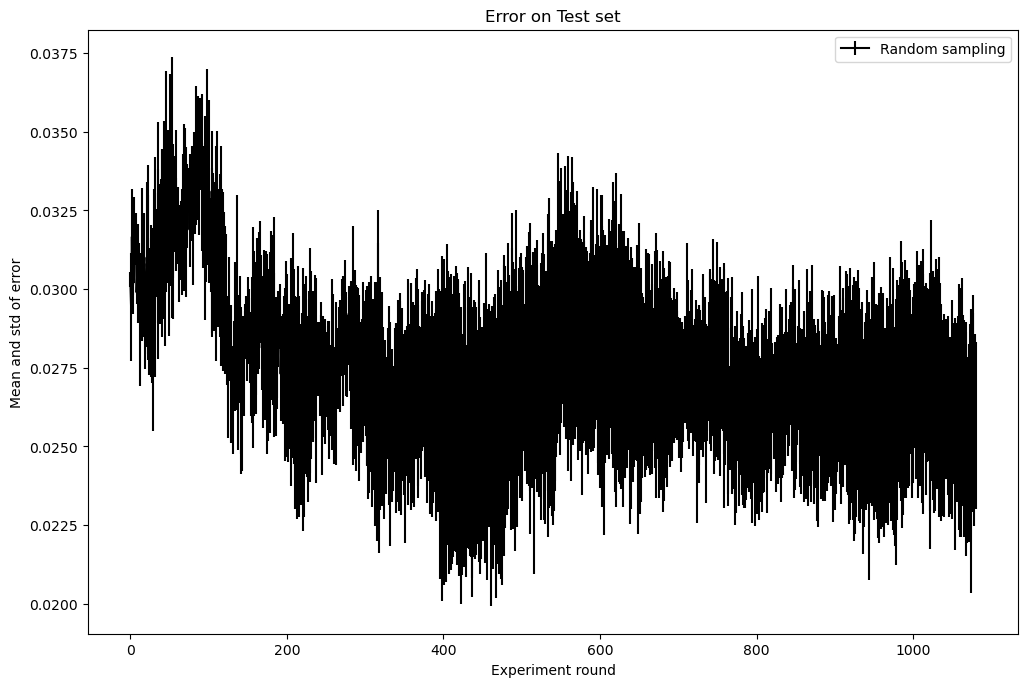

In [91]:
plt.figure(figsize=(12, 8), dpi=100)
round_idx = np.array([i for i in range(1080+1)])
# plt.errorbar(round_idx, uncertainty_unob_mean, uncertainty_unob_std, linestyle='-', marker= None,color = 'red', label = 'Uncertainty sampling')
# plt.errorbar(round_idx, density_unob_mean, density_unob_std, linestyle='-', marker=None,color = 'blue', label = 'Query without a contrain')
# plt.errorbar(round_idx, QBC_unob_mean, QBC_unob_std, linestyle='-', marker=None,color = 'orange', label = 'Query with a contrain')
# plt.errorbar(round_idx, EMC_unob_mean, EMC_unob_std, linestyle='-', marker=None,color = 'green', label = 'Maximize expected model change')
plt.errorbar(round_idx, random_ubob_mean, random_unob_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Error on Test set')
plt.xlabel('Experiment round')
plt.ylabel('Mean and std of error')
plt.legend()
plt.show()

# Uncertainty sampling

In [84]:
# def sort_by_uncertainty(model, ob_data, unob_data):
#     distance_array = np.zeros(shape = (len(unob_data), len(ob_data)))
#     for r, u in enumerate(unob_data):
#         predict = model.predict(u[0:2].reshape(1,2))
#         for c, l in enumerate(ob_data):
#             distance_array[r][c] = abs(predict - l[2])
#     min_dis = distance_array.min(axis = 1)
#     idx = np.argmax(min_dis)
#     return idx

In [85]:
def sort_by_uncertainty(model, ob_data, unob_data):
    var_list = []
    for data in unob_data:
        this_x = data[0:4]
        this_pre = [n.predict(this_x.reshape(1,-1)) for n in model.estimators_]
        var = np.var(this_pre)
        var_list.append(var)
    idx = np.argmax(var_list)
    return idx

In [86]:
print("\nRun uncertainty sampling!")
uncertainty_unob = aggresive_unob(seed_pool, train_set, test_set, 3, 540, regr, sort_by_uncertainty, 54, special_initialization = False)


Run uncertainty sampling!
This is simulation 1


KeyboardInterrupt: 

In [44]:
uncertainty_unob_mean = np.mean(uncertainty_unob, axis = 0)
uncertainty_unob_std = np.std(uncertainty_unob, axis = 0)

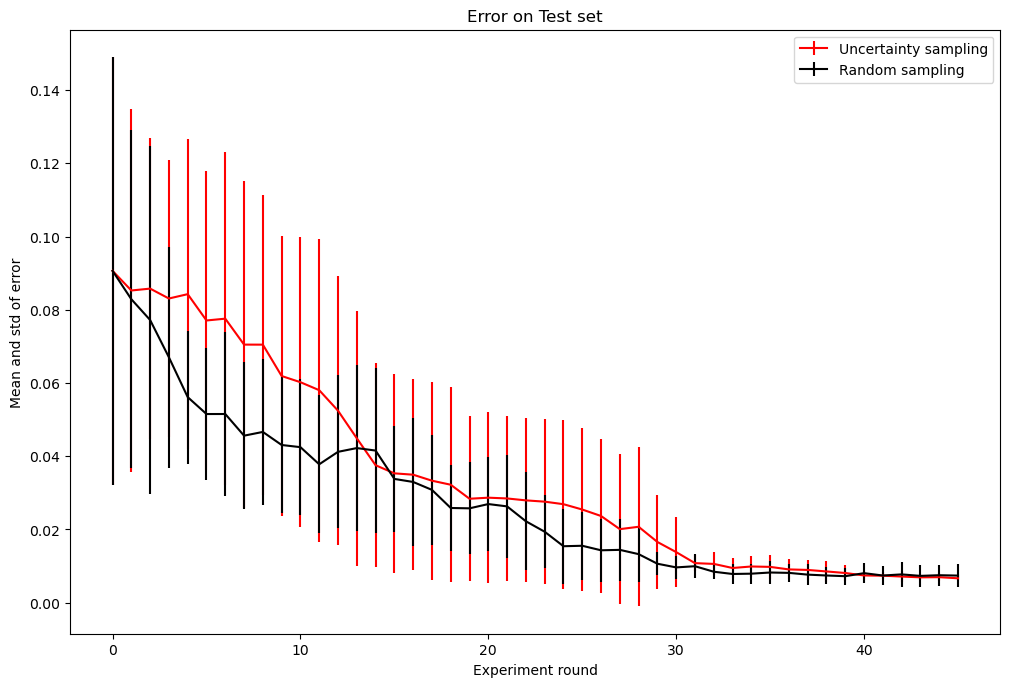

In [46]:
round_idx = np.array([i for i in range(540+1)])
plt.figure(figsize=(12, 8), dpi=100)
plt.errorbar(round_idx, uncertainty_unob_mean, uncertainty_unob_std, linestyle='-', marker= None,color = 'red', label = 'Uncertainty sampling')
# plt.errorbar(round_idx, density_unob_mean, density_unob_std, linestyle='-', marker=None,color = 'blue', label = 'Query without a contrain')
# plt.errorbar(round_idx, QBC_unob_mean, QBC_unob_std, linestyle='-', marker=None,color = 'orange', label = 'Query with a contrain')
# plt.errorbar(round_idx, EMC_unob_mean, EMC_unob_std, linestyle='-', marker=None,color = 'green', label = 'Maximize expected model change')
plt.errorbar(round_idx, random_ubob_mean, random_unob_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Error on Test set')
plt.xlabel('Experiment round')
plt.ylabel('Mean and std of error')
plt.legend()
plt.show()

# Density-based sampling

In [119]:
def radial_basis_function(unlabeled_x):
    average_similarity = []
    for p in unlabeled_x:
        similarity_l = []
        for q in unlabeled_x:
            similarity_l.append(math.exp(-(1/2)*sum((p-q)**2)))
        average_similarity.append(statistics.mean(similarity_l))
    return np.array(average_similarity)

In [120]:
def sort_by_density(model, ob_data, unob_data, beta = 1):
    var_list = []
    for data in unob_data:
        this_x = data[0:2]
        this_pre = [n.predict(this_x.reshape(1,-1)) for n in model.estimators_]
        var = np.var(this_pre)
        var_list.append(var)
    

    similarity = radial_basis_function(unob_data[:,0:2])
    density = var_list * (similarity**beta)
    idx = np.argmax(density)
    return idx

In [121]:
print("\nRun density sampling!")
density_unob = aggresive_unob(seed_pool, train_set, test_set, 10, 45, regr, sort_by_density, 5, special_initialization = False)


Run density sampling!
This is simulation 1
This is simulation 2
This is simulation 3
This is simulation 4
This is simulation 5
This is simulation 6
This is simulation 7
This is simulation 8
This is simulation 9
This is simulation 10


In [122]:
density_unob_mean = np.mean(density_unob, axis = 0)
density_unob_std = np.std(density_unob, axis = 0)

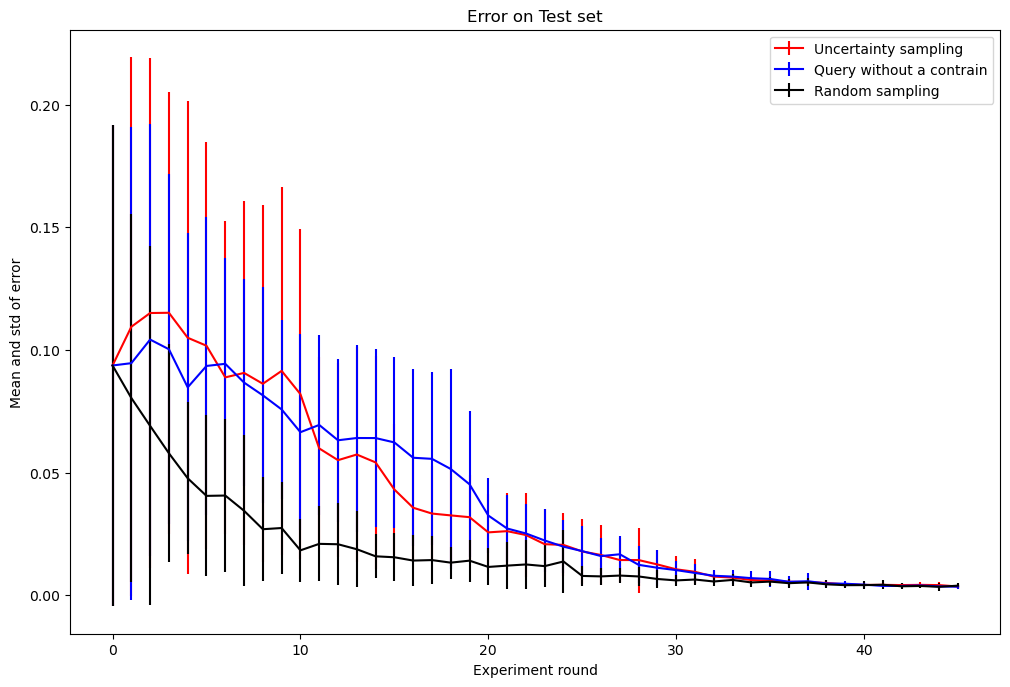

In [123]:

plt.figure(figsize=(12, 8), dpi=100)
plt.errorbar(round_idx, uncertainty_unob_mean, uncertainty_unob_std, linestyle='-', marker= None,color = 'red', label = 'Uncertainty sampling')
plt.errorbar(round_idx, density_unob_mean, density_unob_std, linestyle='-', marker=None,color = 'blue', label = 'Query without a contrain')
# plt.errorbar(round_idx, QBC_unob_mean, QBC_unob_std, linestyle='-', marker=None,color = 'orange', label = 'Query with a contrain')
# plt.errorbar(round_idx, EMC_unob_mean, EMC_unob_std, linestyle='-', marker=None,color = 'green', label = 'Maximize expected model change')
plt.errorbar(round_idx, random_ubob_mean, random_unob_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Error on Test set')
plt.xlabel('Experiment round')
plt.ylabel('Mean and std of error')
plt.legend()
plt.show()

# Query by committee

In [24]:
def construct_committee(ob_data, n_member):
    x_labeled, y_labeled = ob_data[:, 0:2], ob_data[:,2]
    committee = []
    for i in range(n_member):
        bs_idx = np.random.choice(range(len(x_labeled)),len(x_labeled), replace=True)
        bs_x = x_labeled[bs_idx]
        bs_y = y_labeled[bs_idx]
        model_member = LinearRegression()
        model_member.fit(bs_x, bs_y)
        committee.append(model_member)
    return committee

In [25]:
def sort_by_disagrement(model, ob_data, unob_data):
    n_member = 10
    committee = construct_committee(ob_data, n_member)
    pre_matrix = np.zeros((len(unob_data), n_member))
    x_unlabeled = unob_data[:, 0:2]
    for i, m in enumerate(committee):
        one_predict = m.predict(x_unlabeled)
        pre_matrix[:, i] = one_predict
    var = np.var(pre_matrix, axis = 1)
    idx = np.argmax(var)
    return idx 

# Maximize expected model change

In [26]:
def sort_by_EMC(model, ob_data, unob_data):
    x_labeled, y_labeled, x_unlabeled, y_unlabeled = ob_data[:, 0:2], ob_data[:, 2], unob_data[:,0:2], unob_data[:,2]
    n_member = 10
    committee = construct_committee(ob_data,n_member)
    model_change = []
    for u in x_unlabeled:
        curr_model_predict = model.predict(u.reshape(1,-1))
        u_model_change = 0
        for m in committee:
            u_model_change += sum(((curr_model_predict - m.predict(u.reshape(1,-1)))*u)**2)
        model_change.append(u_model_change)
    idx = np.argmax(model_change)
    return idx   

# Error of unobserved data

In [ ]:

print("\nRun density-based sampling!")
density_unob = aggresive_unob(seed_pool, data, simulation_round, 10, LR, sort_by_density, 5, special_initialization = False)
print("\nRun QBC sampling!")
QBC_unob = aggresive_unob(seed_pool, data, simulation_round, 10, LR, sort_by_disagrement, 5, special_initialization = False)
print("\nRun MEMC sampling!")
EMC_unob = aggresive_unob(seed_pool, data, simulation_round, 10, LR, sort_by_EMC, 5, special_initialization = False)

random_ubob_mean = np.mean(random_unob, axis = 0)
random_unob_std = np.std(random_unob, axis = 0)
uncertainty_unob_mean = np.mean(uncertainty_unob, axis = 0)
uncertainty_unob_std = np.std(uncertainty_unob, axis = 0)
density_unob_mean = np.mean(density_unob, axis = 0)
density_unob_std = np.std(density_unob, axis = 0)
QBC_unob_mean = np.mean(QBC_unob, axis = 0)
QBC_unob_std = np.std(QBC_unob, axis = 0)
EMC_unob_mean = np.mean(EMC_unob, axis = 0)
EMC_unob_std = np.std(EMC_unob, axis = 0)


In [39]:

round_idx = np.array([i for i in range(10+1)])
plt.figure(figsize=(12, 8), dpi=100)

plt.errorbar(round_idx, uncertainty_unob_mean, uncertainty_unob_std, linestyle='-', marker= None,color = 'red', label = 'Uncertainty sampling')
plt.errorbar(round_idx, density_unob_mean, density_unob_std, linestyle='-', marker=None,color = 'blue', label = 'Query without a contrain')
plt.errorbar(round_idx, QBC_unob_mean, QBC_unob_std, linestyle='-', marker=None,color = 'orange', label = 'Query with a contrain')
#     plt.errorbar(round_idx, EMC_unob_mean, EMC_unob_std, linestyle='-', marker=None,color = 'green', label = 'Maximize expected model change')
plt.errorbar(round_idx, random_ubob_mean, random_unob_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Error on Test set')
plt.xlabel('Experiment round')
plt.ylabel('Mean and std of error')
plt.legend()
plt.show()